# Notebook 2: Making Predictions

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install PyMC and ArviZ
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pymc3
    !pip install arviz

In [2]:
# PyMC generates a FutureWarning we don't need to deal with yet

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import seaborn as sns

def plot_hist(sample, **options):
    """Plot a histogram of goals.
    
    sample: sequence of values
    """
    sns.histplot(sample, stat='probability', discrete=True,
                 alpha=0.5, **options)

In [4]:
import matplotlib.pyplot as plt

def legend(**options):
    """Make a legend only if there are labels."""
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)
        
def decorate_goals(ylabel='Probability'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    legend()

In [5]:
def plot_kde(sample, **options):
    """Plot a distribution using KDE.
    
    sample: sequence of values
    """
    sns.kdeplot(sample, cut=0, **options)

In [6]:
def decorate_rate(ylabel='Likelihood'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    legend()

## Prediction

In the previous notebook, we defined a model with a goal-scoring rate drawn from a gamma distribution and a number of goals drawn from a Poisson distribution.

We defined a prior distribution for the goal-scoring rate, `mu`, and computed the prior predictive distribution, which is the distribution of goals based on the prior distribution.

Then we used PyMC to draw a sample from the posterior distribution, which is what we believe about `mu` based on observed data.
And we used a two-team model to compute the probability of superiority, which is the chance that one team is better than another -- in the sense of having a higher goal-scoring rate -- based on an observed outcome.

Now let's turn to the task of prediction; that is, given what we believe about `mu`, what distribution of goals should we expect if the same teams play again.
From that we can compute the probability that each team would win a rematch.

Here's the one-team model from the previous notebook, again.

In [7]:
alpha = 4.6
beta = 1.9

In [8]:
import pymc3 as pm

model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


And here's the posterior distribution of `mu`.

In [9]:
sample_posterior = trace['mu']
len(sample_posterior)

2000

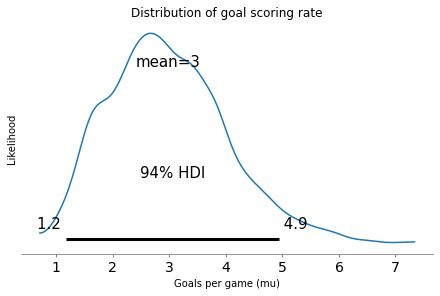

In [10]:
import arviz as az

az.plot_posterior(sample_posterior)
decorate_rate()

## Posterior predictive distribution

That tells us what we should believe about `mu` after we see the data, but it doesn't tell us how many goals we should expect in the future.
For that, we need the **posterior predictive distribution**, which we can get by running `sample_posterior_predictive`:

In [11]:
with model:
    post_pred = pm.sample_posterior_predictive(trace)

The result is similar to the trace we got from `sample`, but it contains a sample of `goals` rather than `mu`.

In [33]:
sample_post_pred = post_pred['goals']
sample_post_pred.mean()

KeyError: 'goals'

And here's what it looks like.

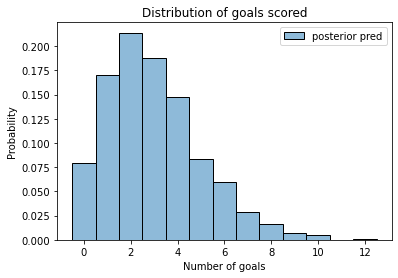

In [13]:
plot_hist(sample_post_pred, label='posterior pred')
decorate_goals()

## Two teams

Continuing the example from the previous notebook, suppose two teams have played each other  twice, Team A wins the first game 5-1 and the second game 3-1.
The following model computes the posterior distribution for each team based on these outcomes.

In [14]:
model = pm.Model()

with model:
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5,3])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1,1])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Here are the results.

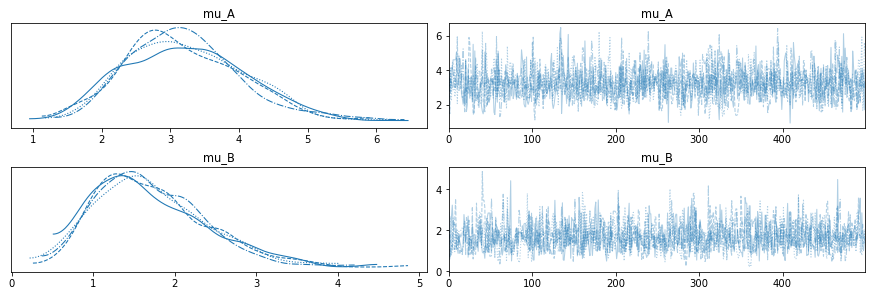

In [15]:
import arviz as az

with model:
    az.plot_trace(trace);

And here are the posterior distributions for `mu_B` and `mu_A`.

In [16]:
mu_A = trace['mu_A']
mu_B = trace['mu_B']
mu_B.mean(), mu_A.mean()

(1.7039484152868747, 3.2390908952252166)

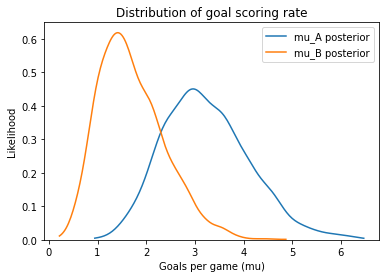

In [17]:
plot_kde(mu_A, label='mu_A posterior')
plot_kde(mu_B, label='mu_B posterior')
decorate_rate()

And here's the probability of superiority.

In [18]:
(mu_A > mu_B).mean()

0.9105

Based on the results, we can be fairly confident that A is the better team, but that doesn't necessarily mean they will win the next game.

## Predictions

To compute the probability that A wins the next game, we can use `sample_posterior_predictive` to generate predictions.

In [19]:
with model:
    post_pred = pm.sample_posterior_predictive(trace)

The prediction for each is an array, so I'll flatten it into a sequence. 

In [20]:
goals_A = post_pred['goals_A']
goals_A.shape

(2000, 2)

Here are the posterior predictive distributions of goals scored.

In [21]:
goals_A = post_pred['goals_A'].flatten()
goals_B = post_pred['goals_B'].flatten()

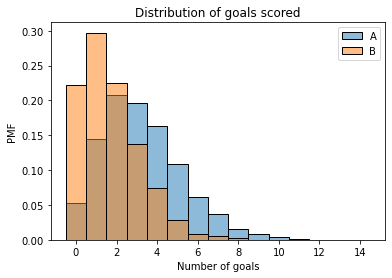

In [22]:
plot_hist(goals_A, label='A')
plot_hist(goals_B, color='C1', label='B')
decorate_goals('PMF')

Team B is more likely than Team A to score 0, 1, or 2 goals.
Team A is more likely to score 3 or more.

Here's the chance that A wins the next game.

In [23]:
win = (goals_A > goals_B).mean()
win

0.655

The chance that they lose.

In [24]:
lose = (goals_B > goals_A).mean()
lose

0.201

And the chance of a tie.

In [25]:
tie = (goals_B == goals_A).mean()
tie

0.144

## Sudden death

In overtime, whichever team scores first wins. If we treat goal-scoring as a Poisson process, the time until the next goal is exponential with parameter `1/mu`.

We can use the samples from the posterior distributions to generate samples from the posterior predictive distribution of time until the next goal, in units of games.

In [26]:
t_A = pm.Exponential.dist(mu_A).random(1000)
t_A.mean()

0.3287123126190606

In [27]:
t_B = pm.Exponential.dist(mu_B).random(1000)
t_B.mean()

0.6992378173570362

On average, we expect it to take longer for Team B to score. But the game isn't decided by averages.

**Exercise:** Compute the probability that Team A wins in overtime, then compute their total probability of winning the next game.

In [28]:
# Solution

prob_win_ot = (t_A < t_B).mean()
prob_win_ot

0.6685

In [29]:
# Solution

prob_win = win + tie * prob_win_ot
prob_win

0.751264

**Bonus exercise:** What is their probability of winning at least 2 of the remaining 5 games in the series?

Hint: Use `pm.Binomial.dist` to draw a sample of wins from a binomial distribution with `n=5` and `p=prob_win`.

In [30]:
# Solution

sample_wins = pm.Binomial.dist(5, prob_win).random(size=1000)

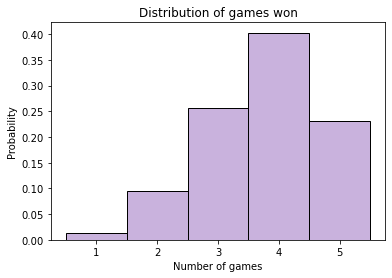

In [31]:
# Solution

plot_hist(sample_wins, color='C4')
plt.xlabel('Number of games')
plt.ylabel('Probability')
plt.title('Distribution of games won');

In [32]:
# Solution

(sample_wins >= 2).mean()

0.986